# calculates the seasonal anomalies and the seasonal tercile categories from the gridded VCSN monthly files, using the NZ 6 regions shapefiles 

In [1]:
# Paramaters 

# var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
var_name = 'Tmean'
# var_name = 'SoilM'
# var_name = 'Wind'
# var_name = 'Rad'

in ['Agent', 'Lat', 'Longt', 'Date', 'MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N']

In [2]:
import os
import sys
import pathlib

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from itertools import product

In [6]:
import salem
import geopandas as gpd
import regionmask

In [7]:
import xarray as xr

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [8]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [9]:
var_name

'Tmean'

### big_var is the simplified version of the variable, so Rain_bc --> RAIN

In [10]:
big_var = var_name.split('_')[0].upper()

In [11]:
HOME = pathlib.Path.home()

In [12]:
dpath = HOME / 'operational/VCSN/data/NC/MONTHLY/' / var_name.upper()

In [13]:
var_name.upper()

'TMEAN'

In [14]:
dpath

PosixPath('/home/nicolasf/operational/VCSN/data/NC/MONTHLY/TMEAN')

In [15]:
dset = salem.open_xr_dataset(dpath / f'VCSN_gridded_{var_name}_1979-01_2019-12.nc') 

In [16]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
Data variables:
    agent    (lat, lon) float32 ...
    Tmean    (time, lat, lon) float64 ...
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

### calculates the seasonal average (or sum if Rain_bc is the variable )

In [17]:
if var_name == 'Rain_bc': 
    dset = dset.rolling(time=3, min_periods=3).sum()
else: 
    dset = dset.rolling(time=3, min_periods=3).mean()

In [18]:
dset = dset.isel(time=slice(2,None))

In [19]:
nz_regions = gpd.read_file(HOME / 'research' / 'Smart_Ideas' / 'data' / 'shapefiles' / 'NZ_regions' / 'NZ_6_regions' / 'NZ_regions_corrected.shp') 

In [20]:
nz_regions

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."
5,6,6,5,42.941379,9.057410,WSI,"MULTIPOLYGON (((169.20749 -46.66371, 169.20742..."


#### checks that the crs is correct: should be epsg 4272 

In [21]:
nz_regions.crs

<Geographic 2D CRS: EPSG:4272>
Name: NZGD49
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: New Zealand - onshore and nearshore
- bounds: (165.87, -47.65, 179.27, -33.89)
Datum: New Zealand Geodetic Datum 1949
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [72]:
regions_xarray = regionmask.from_geopandas(nz_regions)

In [73]:
regions_mask = regions_xarray.mask(dset.lon.data, dset.lat.data)

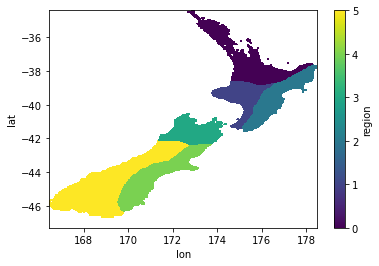

In [74]:
regions_mask.plot()

In [75]:
regions_mask['NNI'] = (('lat', 'lon'), (regions_mask.where(regions_mask==0, np.nan) + 1))

regions_mask['WNI'] = (('lat', 'lon'), (regions_mask.where(regions_mask==1, np.nan) + 0 ))

regions_mask['ENI'] = (('lat', 'lon'), (regions_mask.where(regions_mask==2, np.nan) - 1))

regions_mask['NSI'] = (('lat', 'lon'), (regions_mask.where(regions_mask==3, np.nan) - 2))

regions_mask['WSI'] = (('lat', 'lon'), (regions_mask.where(regions_mask==5, np.nan) - 4))

regions_mask['ESI'] = (('lat', 'lon'), (regions_mask.where(regions_mask==4, np.nan) - 3))

In [78]:
regions_mask.to_netcdf('/media/nicolasf/END19101/data/VCSN/NZ_6_regions_mask.nc')

In [80]:
!pwd

/home/nicolasf/research/Smart_Ideas/code/targets/VCSN
